# Python Data Analytics Mini-Project
##### Shuhan YANG 406545328

In [2]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')


## Connection

In [3]:
endpoint = "127.0.0.1"
username = "root"
port = 3306
database = "mini_project"

In [4]:
load_dotenv()
secret_password = os.getenv("MYSQL_PASSWORD", "")

In [5]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

## Visualizations

### 1. Total Sales by Category and Total Profits by Category

In [6]:
# Query for sales by category
query = """
SELECT 
    p.category,
    SUM(oi.sales) as total_sales,
    SUM(oi.profit) as total_profit,
    COUNT(oi.row_id) as total_orders
FROM order_items oi
JOIN products p ON (oi.product_id = p.product_id AND oi.product_name = p.product_name)
GROUP BY p.category
ORDER BY total_sales DESC
"""

In [7]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

df = pd.read_sql(query, connection)
connection.close()
print(df.head())

          category  total_sales  total_profit  total_orders
0       Technology    836154.10   145454.9481          1847
1        Furniture    741999.98    18451.2728          2121
2  Office Supplies    719046.99   122490.8008          6026


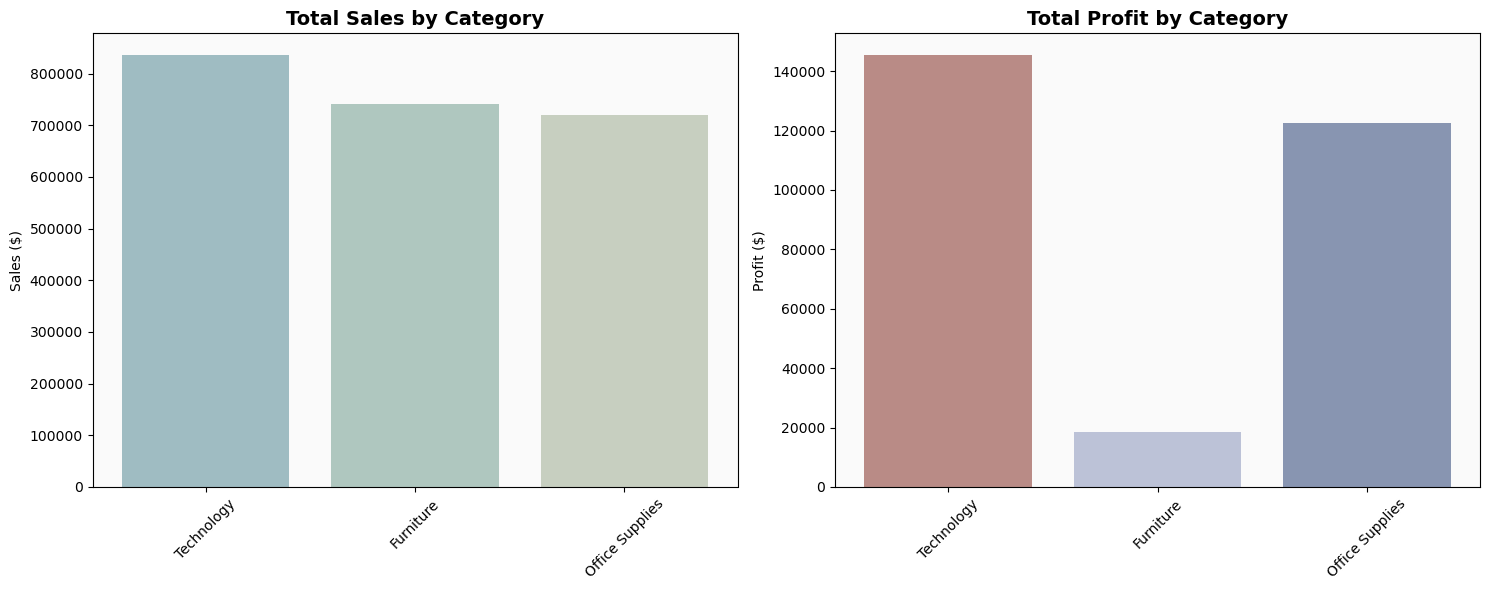

In [8]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Sales by category
ax1.bar(df['category'], df['total_sales'], color=['#9FBCC2', '#AFC7BF', '#C7CFC0'])
ax1.set_title('Total Sales by Category', fontsize=14, fontweight='bold')
ax1.set_ylabel('Sales ($)')
ax1.tick_params(axis='x', rotation=45)

# Profit by category
ax2.bar(df['category'], df['total_profit'], color=['#B98B86', '#BCC2D7', '#8895B1'])
ax2.set_title('Total Profit by Category', fontsize=14, fontweight='bold')
ax2.set_ylabel('Profit ($)')
ax2.tick_params(axis='x', rotation=45)

ax1.set_facecolor('#fafafa')
ax2.set_facecolor('#fafafa')

plt.tight_layout()
plt.savefig('sales_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Regional Performance

In [9]:
# Query for regional performance
query = """
SELECT 
    l.region,
    l.state,
    SUM(oi.sales) as total_sales,
    SUM(oi.profit) as total_profit,
    COUNT(DISTINCT o.order_id) as order_count,
    AVG(oi.sales) as avg_order_value
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN locations l ON o.location_id = l.location_id
GROUP BY l.region, l.state
ORDER BY total_sales DESC
"""

In [10]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

df = pd.read_sql(query, connection)
connection.close()
print(df.head())

    region         state  total_sales  total_profit  order_count  \
0     West    California    457687.68    76381.3871         1021   
1     East      New York    310876.20    74038.5486          562   
2  Central         Texas    170187.98   -25729.3563          487   
3     West    Washington    138641.29    33402.6517          256   
4     East  Pennsylvania    116512.02   -15559.9603          288   

   avg_order_value  
0       228.729475  
1       275.599468  
2       172.779675  
3       273.994644  
4       198.487257  


In [11]:
# Create regional summary
regional_summary = df.groupby('region').agg({
    'total_sales': 'sum',
    'total_profit': 'sum',
    'order_count': 'sum',
    'avg_order_value': 'mean'
}).reset_index()

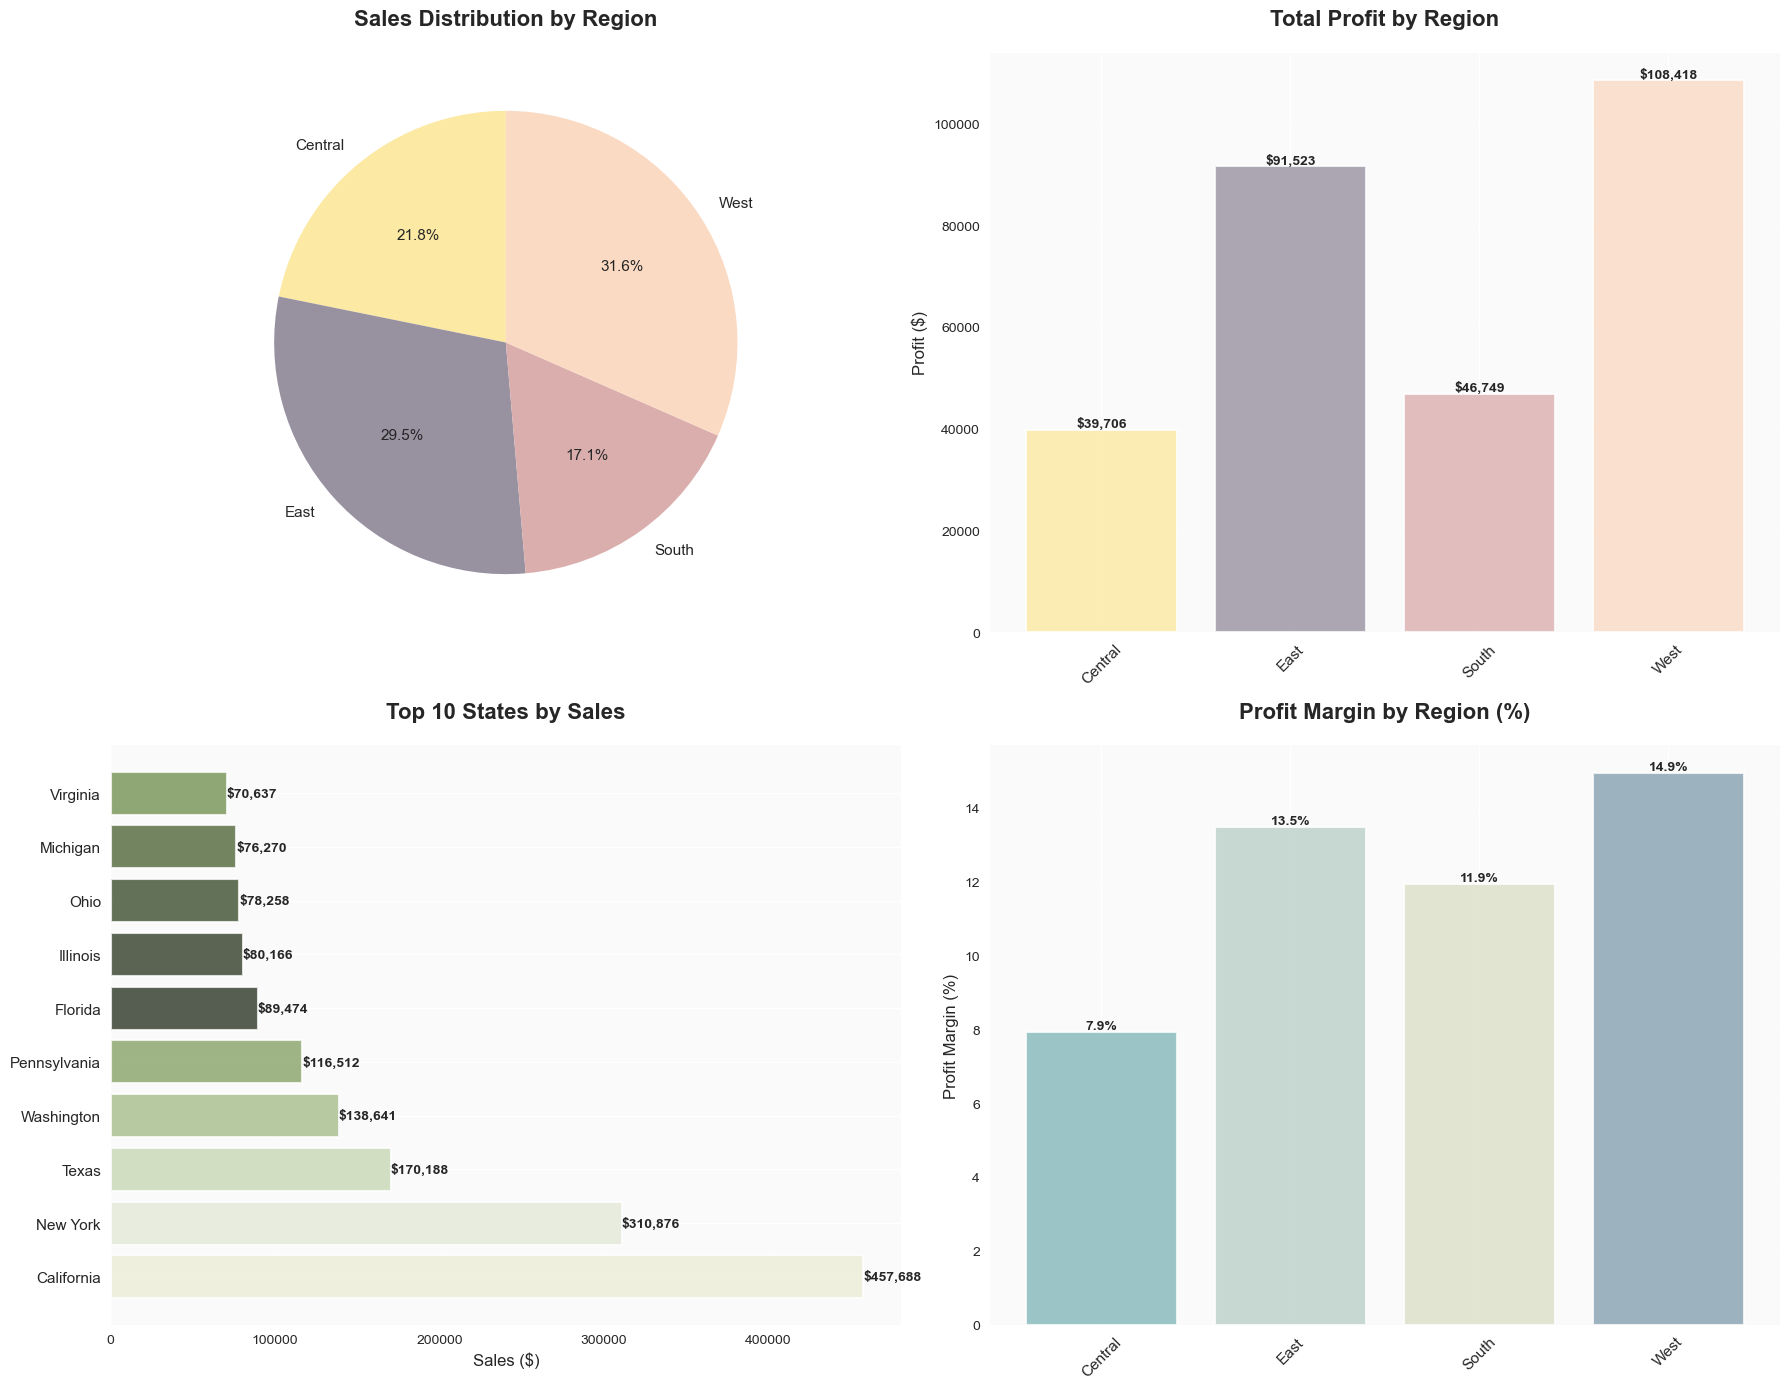

In [12]:
# Create visualization
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

region_colors = ['#FCE9A3', '#9791A0', '#DBAEAE', '#FBDAC3']
state_colors = ['#EBEDD6', '#E3E9D7', '#C8D7B4', '#A5BD8A', '#87A368', 
                '#2C3725', '#333F29', '#3D4F2F', '#50673A', '#739353']

# 1. Sales by Region (Pie Chart)
ax1.pie(regional_summary['total_sales'], labels=regional_summary['region'], 
        autopct='%1.1f%%', startangle=90, colors=region_colors,
        textprops={'fontsize': 11})
ax1.set_title('Sales Distribution by Region', fontsize=16, fontweight='bold', pad=20)

# 2. Profit by Region (Bar Chart)
bars2 = ax2.bar(regional_summary['region'], regional_summary['total_profit'], 
                color=region_colors, alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_title('Total Profit by Region', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Profit ($)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_facecolor('#fafafa')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Top 10 States by Sales
top_states = df.nlargest(10, 'total_sales')
bars3 = ax3.barh(range(len(top_states)), top_states['total_sales'], 
                 color=state_colors[:len(top_states)], alpha=0.8, 
                 edgecolor='white', linewidth=1.5)
ax3.set_yticks(range(len(top_states)))
ax3.set_yticklabels(top_states['state'], fontsize=11)
ax3.set_title('Top 10 States by Sales', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Sales ($)', fontsize=12)
ax3.grid(axis='x', alpha=0.3)
ax3.set_facecolor('#fafafa')

for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f'${width:,.0f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

# 4. Profit Margin by Region
regional_summary['profit_margin'] = (regional_summary['total_profit'] / 
                                    regional_summary['total_sales']) * 100
bars4 = ax4.bar(regional_summary['region'], regional_summary['profit_margin'], 
                color=['#82b7b9', '#b9d0c7', '#dcdfc9', '#86a0b1'], 
                alpha=0.8, edgecolor='white', linewidth=1.5)
ax4.set_title('Profit Margin by Region (%)', fontsize=16, fontweight='bold', pad=20)
ax4.set_ylabel('Profit Margin (%)', fontsize=12)
ax4.tick_params(axis='x', rotation=45, labelsize=11)
ax4.grid(axis='y', alpha=0.3)
ax4.set_facecolor('#fafafa')

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('regional_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Customer Segmentation

In [13]:
query = """
SELECT 
    c.segment,
    COUNT(DISTINCT c.customer_id) as customer_count,
    SUM(oi.sales) as total_sales,
    SUM(oi.profit) as total_profit,
    AVG(oi.sales) as avg_order_value,
    COUNT(oi.row_id) as total_orders
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.segment
ORDER BY total_sales DESC
"""

In [14]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

df = pd.read_sql(query, connection)
connection.close()
print(df.head())

       segment  customer_count  total_sales  total_profit  avg_order_value  \
0     Consumer             409   1161401.34   134119.2092       223.733643   
1    Corporate             236    706146.44    91979.1340       233.823325   
2  Home Office             148    429653.29    60298.6785       240.972120   

   total_orders  
0          5191  
1          3020  
2          1783  


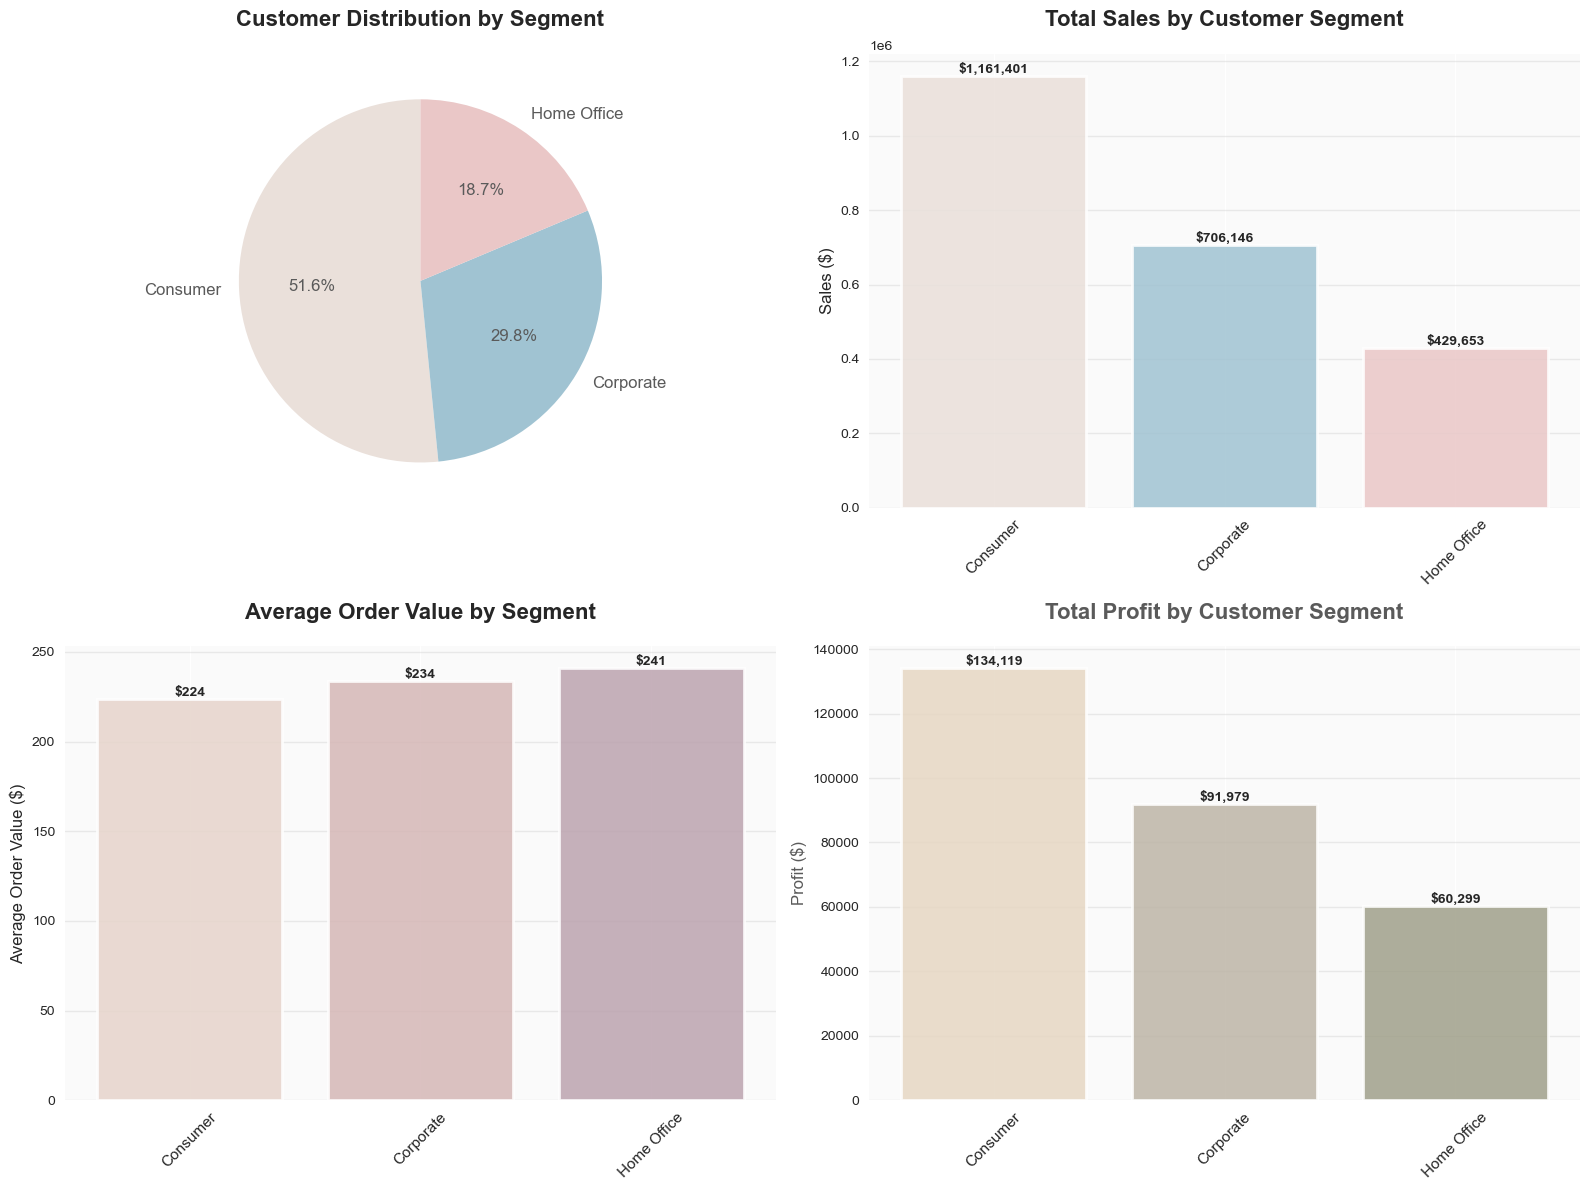

In [15]:
# Create visualization
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

segments = ['#eae0da', '#A0C3D2', '#EAC7C7']
segments2 = ['#E6D4CB', '#D5B7B6', '#BCA3AF']

# 1. Customer Count by Segment (Pie Chart)
ax1.pie(df['customer_count'], labels=df['segment'], autopct='%1.1f%%', 
        startangle=90, colors=segments, 
        textprops={'fontsize': 12, 'color': '#5A5A5A'})
ax1.set_title('Customer Distribution by Segment', fontsize=16, fontweight='bold', 
              pad=20)

# 2. Total Sales by Segment
bars2 = ax2.bar(df['segment'], df['total_sales'], 
                color=segments, alpha=0.85, edgecolor='white', linewidth=2)
ax2.set_title('Total Sales by Customer Segment', fontsize=16, fontweight='bold', 
              pad=20)
ax2.set_ylabel('Sales ($)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.tick_params(axis='y')
ax2.grid(axis='y', alpha=0.3, color='#C0C0C0')
ax2.set_facecolor('#fafafa')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
# 3. Average Order Value by Segment
bars3 = ax3.bar(df['segment'], df['avg_order_value'], 
                color=segments2, alpha=0.85, edgecolor='white', linewidth=2)
ax3.set_title('Average Order Value by Segment', fontsize=16, fontweight='bold', 
              pad=20)
ax3.set_ylabel('Average Order Value ($)', fontsize=12)
ax3.tick_params(axis='x', rotation=45, labelsize=11)
ax3.tick_params(axis='y')
ax3.grid(axis='y', alpha=0.3, color='#C0C0C0')
ax3.set_facecolor('#fafafa') 

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
# 4. Total Profit by Segment
bars4 = ax4.bar(df['segment'], df['total_profit'], 
                color=['#E6D7C3', '#BDB5A7', '#A0A08A'], alpha=0.85, 
                edgecolor='white', linewidth=2)
ax4.set_title('Total Profit by Customer Segment', fontsize=16, fontweight='bold', 
              pad=20, color='#5A5A5A')
ax4.set_ylabel('Profit ($)', fontsize=12, color='#5A5A5A')
ax4.tick_params(axis='x', rotation=45, labelsize=11)
ax4.tick_params(axis='y')
ax4.grid(axis='y', alpha=0.3, color='#C0C0C0')
ax4.set_facecolor('#fafafa')

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
plt.tight_layout()
plt.savefig('customer_segmentation.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### 4. Time Series Analysis

In [16]:
# Query for time series analysis
query = """
SELECT 
    DATE_FORMAT(o.order_date, '%Y-%m') as order_month,
    SUM(oi.sales) as monthly_sales,
    SUM(oi.profit) as monthly_profit,
    COUNT(DISTINCT o.order_id) as monthly_orders,
    AVG(oi.sales) as avg_monthly_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY DATE_FORMAT(o.order_date, '%Y-%m')
ORDER BY order_month
"""

In [17]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

df = pd.read_sql(query, connection)
connection.close()
print(df.head())

  order_month  monthly_sales  monthly_profit  monthly_orders  \
0     2014-01       14236.90       2450.1907              32   
1     2014-02        4519.92        862.3084              28   
2     2014-03       55691.04        498.7299              71   
3     2014-04       28295.35       3488.8352              66   
4     2014-05       23648.28       2738.7096              69   

   avg_monthly_order_value  
0               180.213924  
1                98.259130  
2               354.720000  
3               209.595185  
4               193.838361  


In [18]:
# Convert order_month to datetime
df['order_month'] = pd.to_datetime(df['order_month'])

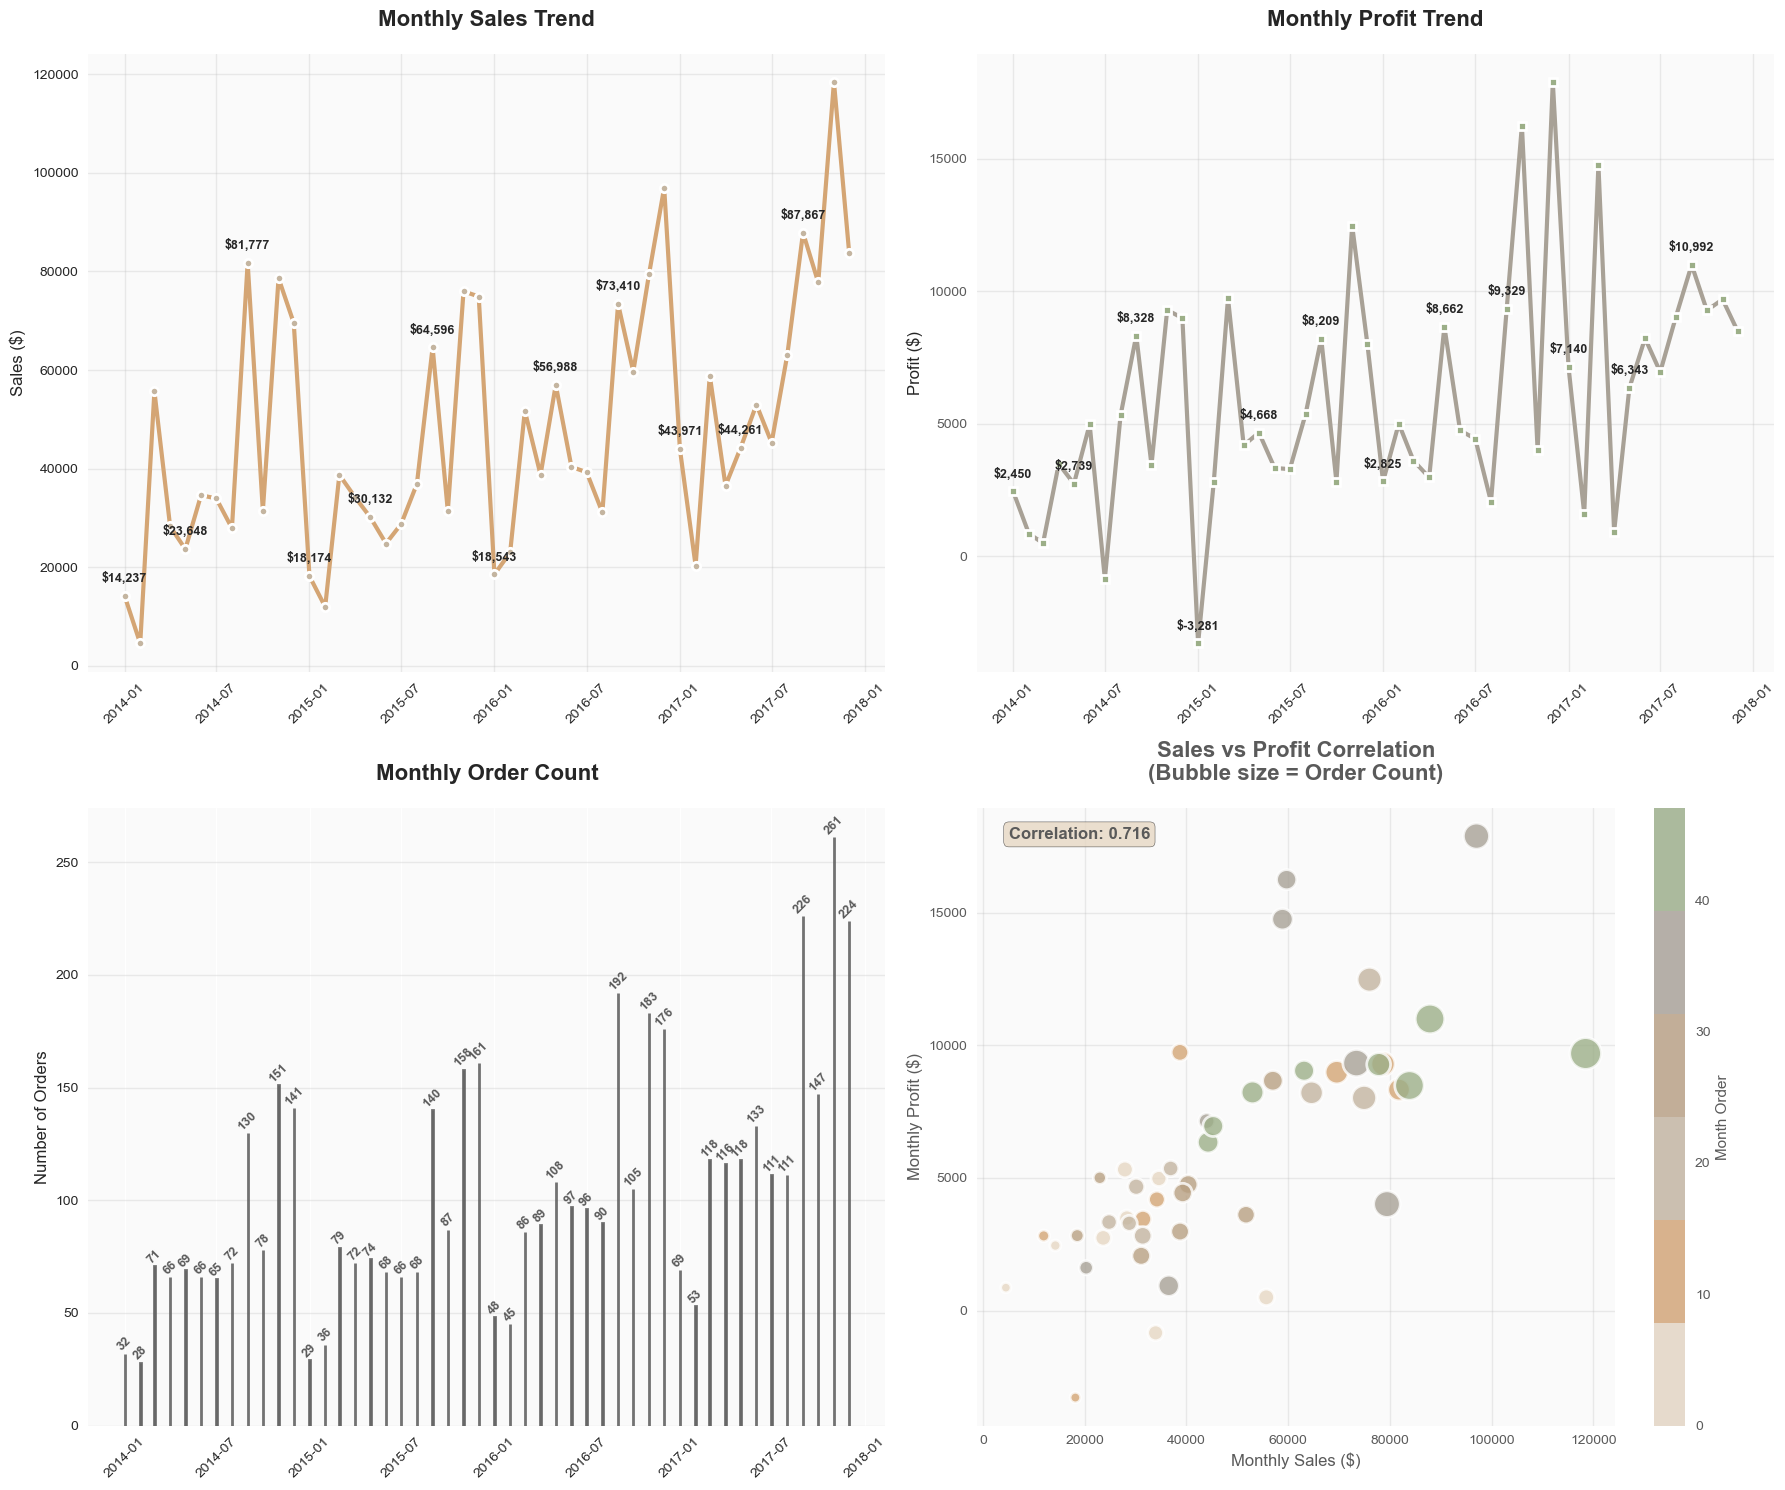

In [19]:
# Create visualization
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15))

# 1. Monthly Sales Trend
ax1.plot(df['order_month'], df['monthly_sales'], marker='o', linewidth=3, 
         markersize=6, color='#D4A574', markerfacecolor='#C4B5A0', 
         markeredgecolor='white', markeredgewidth=2)
ax1.set_title('Monthly Sales Trend', fontsize=16, fontweight='bold', 
              pad=20)
ax1.set_ylabel('Sales ($)', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3, color='#C0C0C0')
ax1.set_facecolor('#fafafa') 

for i in range(0, len(df), 4):
    ax1.annotate(f'${df.iloc[i]["monthly_sales"]:,.0f}', 
                (df.iloc[i]['order_month'], df.iloc[i]['monthly_sales']),
                textcoords="offset points", xytext=(0,10), ha='center',
                fontsize=9, fontweight='bold')
    
# 2. Monthly Profit Trend
ax2.plot(df['order_month'], df['monthly_profit'], marker='s', linewidth=3, 
         markersize=6, color='#A8A196', markerfacecolor='#9CAF88',
         markeredgecolor='white', markeredgewidth=2)
ax2.set_title('Monthly Profit Trend', fontsize=16, fontweight='bold', 
              pad=20)
ax2.set_ylabel('Profit ($)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.tick_params(axis='y', colors='#5A5A5A')
ax2.grid(True, alpha=0.3, color='#C0C0C0')
ax2.set_facecolor('#fafafa')

for i in range(0, len(df), 4):
    ax2.annotate(f'${df.iloc[i]["monthly_profit"]:,.0f}', 
                (df.iloc[i]['order_month'], df.iloc[i]['monthly_profit']),
                textcoords="offset points", xytext=(0,10), ha='center',
                fontsize=9, fontweight='bold')
    
# 3. Monthly Order Count
bars3 = ax3.bar(df['order_month'], df['monthly_orders'], alpha=0.85, 
                color='#5A5A5A', edgecolor='#5A5A5A', linewidth=2)
ax3.set_title('Monthly Order Count', fontsize=16, fontweight='bold', 
              pad=20)
ax3.set_ylabel('Number of Orders', fontsize=12)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.tick_params(axis='y')
ax3.grid(axis='y', alpha=0.3, color='#C0C0C0')
ax3.set_facecolor('#fafafa') 

for i in range(0, len(df)):
    bar_height = df.iloc[i]['monthly_orders']
    ax3.text(df.iloc[i]['order_month'], bar_height,
             f'{bar_height:,}',
             ha='center', va='bottom', fontsize=9, fontweight='bold',
             color='#5A5A5A', rotation=45)
    
# 4. Sales vs Profit Correlation
colors = cm.colors.ListedColormap(['#E6D7C3', '#D4A574', '#C4B5A0', '#B8A082', '#A8A196', '#9CAF88'])

scatter = ax4.scatter(df['monthly_sales'], df['monthly_profit'], 
                     s=df['monthly_orders']*2, alpha=0.8, 
                     c=range(len(df)), cmap=colors, 
                     edgecolors='white', linewidth=2)
ax4.set_title('Sales vs Profit Correlation\n(Bubble size = Order Count)', 
              fontsize=16, fontweight='bold', pad=20, color='#5A5A5A')
ax4.set_xlabel('Monthly Sales ($)', fontsize=12, color='#5A5A5A')
ax4.set_ylabel('Monthly Profit ($)', fontsize=12, color='#5A5A5A')
ax4.tick_params(colors='#5A5A5A')
ax4.grid(True, alpha=0.3, color='#C0C0C0')
ax4.set_facecolor('#fafafa')

correlation = df['monthly_sales'].corr(df['monthly_profit'])
ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=ax4.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='#E6D7C3', alpha=0.8),
         color='#5A5A5A')

cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Month Order', color='#5A5A5A')
cbar.ax.tick_params(colors='#5A5A5A')

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Region-Segment Analysis

In [20]:
# Query for region-segment analysis
query = """
SELECT 
    l.region,
    c.segment,
    SUM(oi.sales) as total_sales,
    SUM(oi.profit) as total_profit,
    COUNT(DISTINCT o.order_id) as order_count,
    COUNT(DISTINCT c.customer_id) as customer_count,
    AVG(oi.sales) as avg_order_value
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
JOIN locations l ON o.location_id = l.location_id
GROUP BY l.region, c.segment
ORDER BY l.region, c.segment
"""

In [21]:
connection = pymysql.connections.Connection(
    host=endpoint,
    user=username,
    password=secret_password,
    database=database,
    port=port,
    charset='utf8mb4'
)

df = pd.read_sql(query, connection)
connection.close()
print(df.head())

    region      segment  total_sales  total_profit  order_count  \
0  Central     Consumer    252031.43     8564.0481          604   
1  Central    Corporate    157995.79    18703.9020          348   
2  Central  Home Office     91212.66    12438.4124          223   
3     East     Consumer    350908.17    41190.9843          713   
4     East    Corporate    200409.45    23622.5789          434   

   customer_count  avg_order_value  
0             328       207.946724  
1             180       234.763432  
2             121       208.248082  
3             344       238.875541  
4             206       228.517047  


In [22]:
# Create pivot tables for different metrics
sales_pivot = df.pivot(index='region', columns='segment', values='total_sales')
profit_pivot = df.pivot(index='region', columns='segment', values='total_profit')
orders_pivot = df.pivot(index='region', columns='segment', values='order_count')
customers_pivot = df.pivot(index='region', columns='segment', values='customer_count')

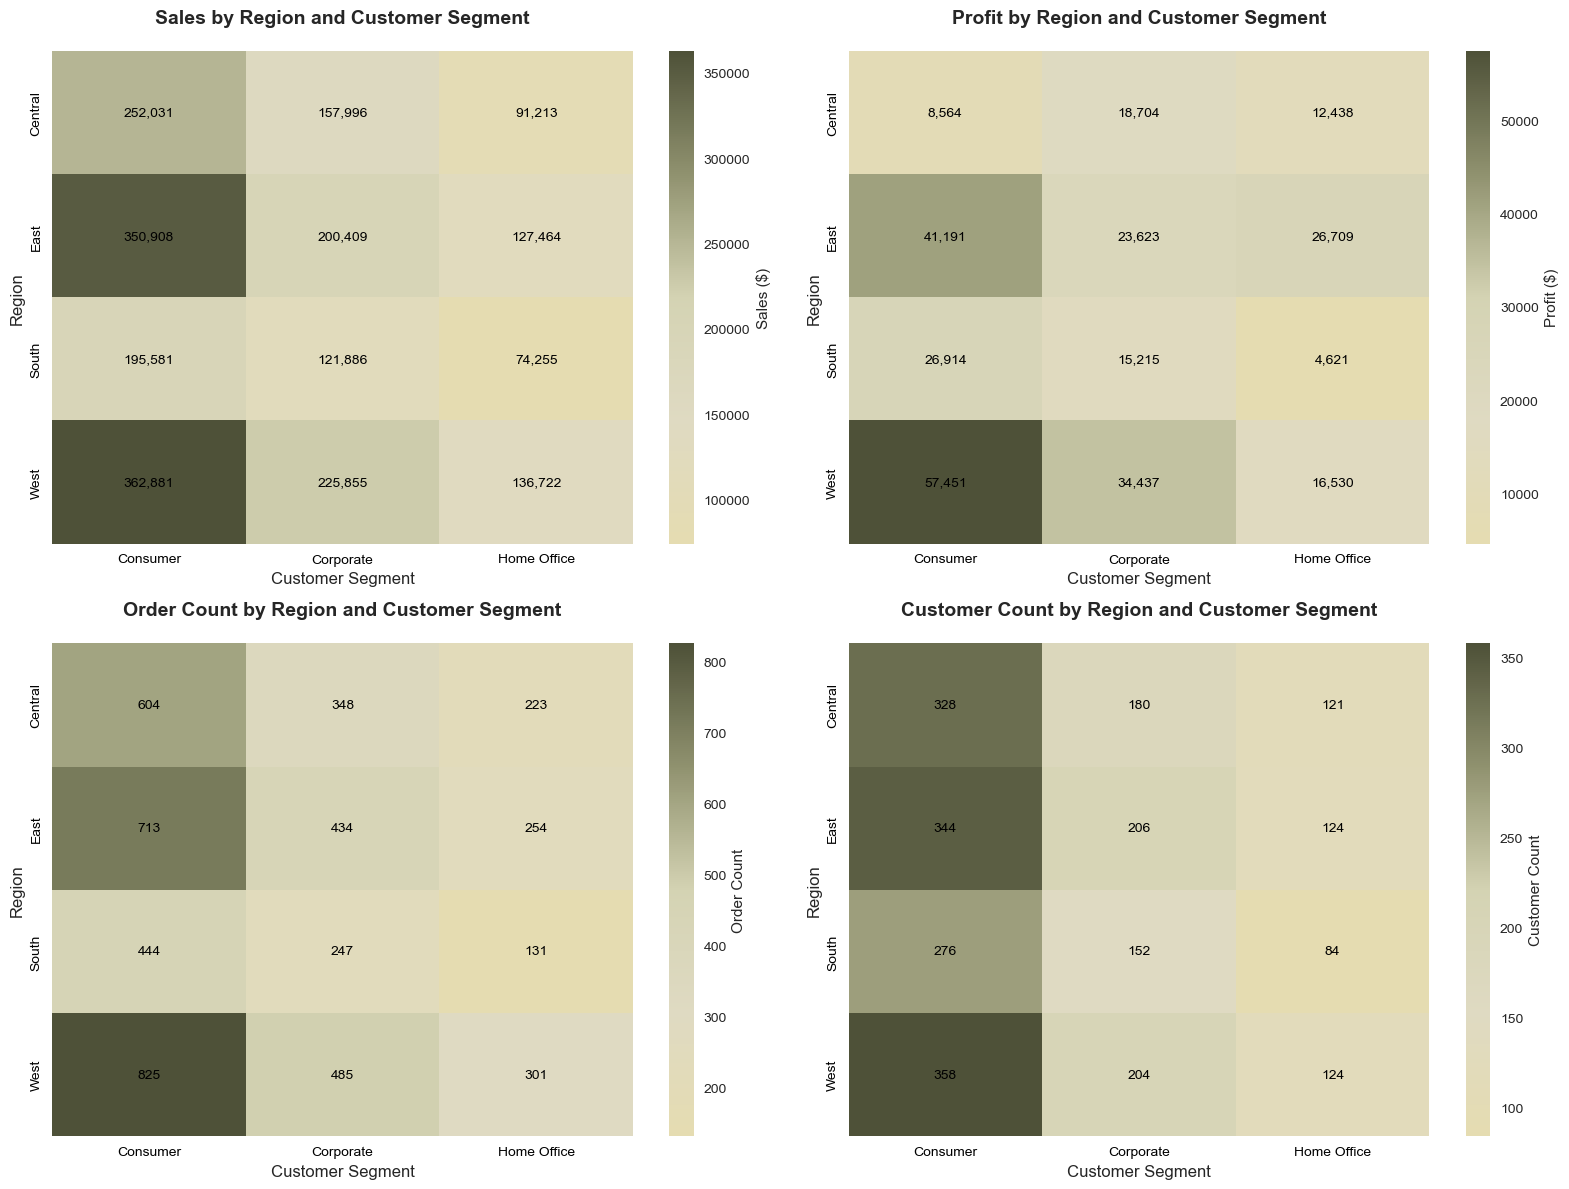

In [23]:
# Create visualization
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

colors = sns.blend_palette(['#E5DCB1', '#DFDAC2', '#D4D3B3', '#90926F', '#4E5138'], as_cmap=True)

# 1. Sales Heatmap
sns.heatmap(sales_pivot, annot=True, fmt=',.0f', cmap=colors, 
            ax=ax1, cbar_kws={'label': 'Sales ($)'}, 
            annot_kws={'fontsize': 10, 'color': 'black'})
ax1.set_title('Sales by Region and Customer Segment', fontsize=14, fontweight='bold', 
              pad=20)
ax1.set_xlabel('Customer Segment', fontsize=12)
ax1.set_ylabel('Region', fontsize=12)
ax1.tick_params(colors='black')

# 2. Profit Heatmap
sns.heatmap(profit_pivot, annot=True, fmt=',.0f', cmap=colors,
            ax=ax2, cbar_kws={'label': 'Profit ($)'},
            annot_kws={'fontsize': 10, 'color': 'black'})
ax2.set_title('Profit by Region and Customer Segment', fontsize=14, fontweight='bold',
              pad=20)
ax2.set_xlabel('Customer Segment', fontsize=12)
ax2.set_ylabel('Region', fontsize=12)
ax2.tick_params(colors='black')

# 3. Order Count Heatmap
sns.heatmap(orders_pivot, annot=True, fmt=',.0f', cmap=colors,
            ax=ax3, cbar_kws={'label': 'Order Count'},
            annot_kws={'fontsize': 10, 'color': 'black'})
ax3.set_title('Order Count by Region and Customer Segment', fontsize=14, fontweight='bold',
              pad=20)
ax3.set_xlabel('Customer Segment', fontsize=12)
ax3.set_ylabel('Region', fontsize=12)
ax3.tick_params(colors='black')

# 4. Customer Count Heatmap
sns.heatmap(customers_pivot, annot=True, fmt=',.0f', cmap=colors,
            ax=ax4, cbar_kws={'label': 'Customer Count'},
            annot_kws={'fontsize': 10, 'color': 'black'})
ax4.set_title('Customer Count by Region and Customer Segment', fontsize=14, fontweight='bold',
              pad=20)
ax4.set_xlabel('Customer Segment', fontsize=12)
ax4.set_ylabel('Region', fontsize=12)
ax4.tick_params(colors='black')

plt.tight_layout()
plt.savefig('region_segment_heatmap.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()